# Deep Q Network로의 여행.
# Part I. Function Approximation : Q-Network

![좋은 그림](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnature14236/MediaObjects/41586_2015_Article_BFnature14236_Fig1_HTML.jpg)

[읽어보면 좋은 것 1](https://arxiv.org/pdf/1312.5602.pdf)<br>
[읽어보면 좋은 것 2](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)



# 라이브러리 설치 / 불러오기

In [1]:
%%time
## 약 25초 ~30초 소요
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
#!pip install pyglet==1.3.2
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
CPU times: user 59.8 ms, sys: 30.4 ms, total: 90.2 ms
Wall time: 12.3 s


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

비디오 녹화용 함수

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# LunarLander-v2
[LunarLander-v2 링크](https://gym.openai.com/envs/LunarLander-v2/)
<br>
<img src='https://miro.medium.com/max/1346/1*i7lxpgt2K3Q8lgEPJu3_xA.png'>



In [5]:
env = wrap_env(gym.make("LunarLander-v2"))
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state = env.reset()
for t in range(1000):
    action = env.action_space.sample() # your agent here (this takes random actions)
    env.render()
    observation, reward, done, info = env.step(action)
    if done: 
      break;
            
print('steps: ', t)
env.close()
show_video()

observation space: Box(-inf, inf, (8,), float32)
action space: Discrete(4)
steps:  75


# Deep Neural Network for Q-function

**Q-function기능을 할 뉴럴넷을 구성할 것이다.**
1. input은 state다. (노드 수는?)
2. output은 그 state에서 취할 수 있는 action에 대한 Q값이다. (노드 수는?)

![좋은그림](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2019/11/20/Fig2-DeepRL-SageMaker.gif)

### State와 Action 정의
* The state. Attributes:
  * s[0] is the horizontal coordinate
  * s[1] is the vertical coordinate
  * s[2] is the horizontal speed
  * s[3] is the vertical speed
  * s[4] is the angle
  * s[5] is the angular speed
  * s[6] 1 if first leg has contact, else 0
  * s[7] 1 if second leg has contact, else 0

* The Action.
  * Nop, fire left engine, main engine, right engine

In [6]:
print("state 수는? : ", env.observation_space.shape)
print("action 수는? : ", env.action_space.n)

state 수는? :  (8,)
action 수는? :  4


**다음과 같이 구성하시오.**
1. Q값에 대한 회귀 문제이다! (아웃풋레이어의 activation은? mse)
2. 히든레이어는 2개를 구성한다.(각각 노드 64개씩)
3. 컴파일 까지!
4. **Functional**하게!  (너무 힘들면 Sequential하게)

In [7]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [8]:
keras.backend.clear_session()
######################
### Your Code Here ###
######################

state_layer = Input(shape=[ env.observation_space.shape[0] ]) #  env.observation_space.shape[0] --> 8
Hidden_layer = Dense(64, activation='swish')(state_layer)
Hidden_layer = Dense(64, activation='swish')(Hidden_layer)
q_layer = Dense(env.action_space.n, activation='softmax')(Hidden_layer)  # env.action_space.n --> 4

Q_network = Model(state_layer, q_layer)

Q_network.compile(loss = 'mse',
              optimizer = Adam())

Q_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________


# Q - Learning

**00_2_SARSA & Qlearning 파일 참고하며 볼 것!**

1. 흐름을 정리하며 봐야 가장 좋다!

In [9]:
env.close()
env = wrap_env(gym.make("LunarLander-v2"))   
s0 = env.reset()
s0  # state 값이 8개 있음

array([-0.00789156,  1.4146273 , -0.79934436,  0.16474256,  0.00915112,
        0.18106338,  0.        ,  0.        ], dtype=float32)

In [10]:
Q_s0 = Q_network.predict(s0.reshape(1,8)) # 2 차원으로 변경해서 입력
print(Q_s0.shape)                         
print(Q_s0)                               # 4개 값으로 된 Action 값 출력
print(np.argmax(Q_s0))                    # 제일 좋은 Action 선택

(1, 4)
[[0.24588491 0.24610184 0.26358294 0.2444304 ]]
2


episode 1 --진행 중
episode 2 --진행 중
episode 3 --진행 중
episode 4 --진행 중
episode 5 --진행 중
episode 6 --진행 중
episode 7 --진행 중
episode 8 --진행 중
episode 9 --진행 중
episode 10 --진행 중
===========  에피소드 : 10  ============
최종 누적 보상 : -156.6279774325207
0 [[0.39538518 0.25228038 0.15928352 0.19305094]]


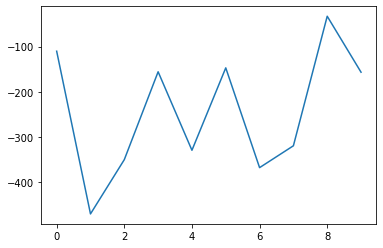

episode 11 --진행 중
episode 12 --진행 중
episode 13 --진행 중
episode 14 --진행 중
episode 15 --진행 중
episode 16 --진행 중
episode 17 --진행 중
episode 18 --진행 중
episode 19 --진행 중
episode 20 --진행 중
===========  에피소드 : 20  ============
최종 누적 보상 : -89.94343085237206
3 [[0.22605063 0.19252835 0.25078937 0.3306316 ]]


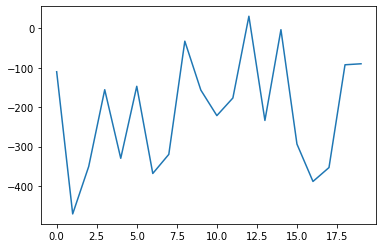

episode 21 --진행 중
episode 22 --진행 중
episode 23 --진행 중
episode 24 --진행 중
episode 25 --진행 중
episode 26 --진행 중
episode 27 --진행 중
episode 28 --진행 중
episode 29 --진행 중
episode 30 --진행 중
===========  에피소드 : 30  ============
최종 누적 보상 : -249.44270728404177
1 [[0.16876146 0.32813182 0.30749363 0.1956131 ]]


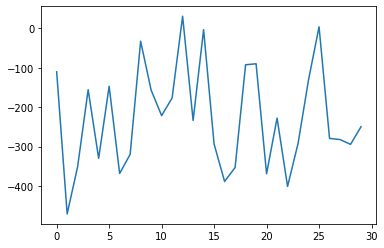

episode 31 --진행 중
episode 32 --진행 중
episode 33 --진행 중
episode 34 --진행 중
episode 35 --진행 중
episode 36 --진행 중
episode 37 --진행 중
episode 38 --진행 중
episode 39 --진행 중
episode 40 --진행 중
===========  에피소드 : 40  ============
최종 누적 보상 : -149.1392306777904
2 [[0.2647491  0.20979956 0.2689811  0.25647014]]


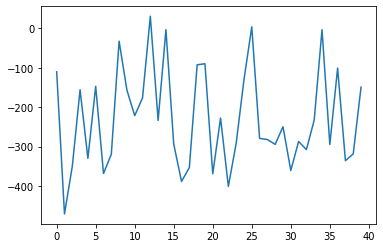

episode 41 --진행 중
episode 42 --진행 중
episode 43 --진행 중
episode 44 --진행 중
episode 45 --진행 중
episode 46 --진행 중
episode 47 --진행 중
episode 48 --진행 중
episode 49 --진행 중
episode 50 --진행 중
===========  에피소드 : 50  ============
최종 누적 보상 : -130.8592532549646
0 [[0.230717   0.2838134  0.25326878 0.23220079]]


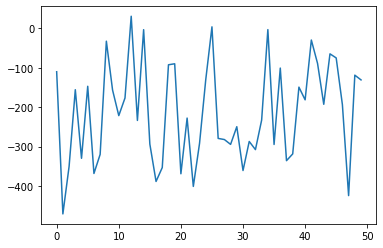

episode 51 --진행 중
episode 52 --진행 중
episode 53 --진행 중
episode 54 --진행 중
episode 55 --진행 중
episode 56 --진행 중
episode 57 --진행 중
episode 58 --진행 중
episode 59 --진행 중
episode 60 --진행 중
===========  에피소드 : 60  ============
최종 누적 보상 : -151.16624766534773
1 [[0.23766422 0.2676326  0.26278433 0.23191878]]


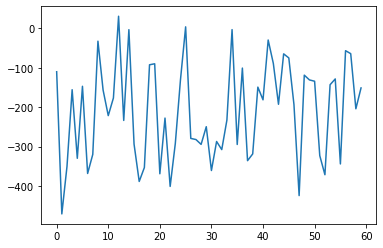

episode 61 --진행 중
episode 62 --진행 중
episode 63 --진행 중
episode 64 --진행 중
episode 65 --진행 중
episode 66 --진행 중
episode 67 --진행 중
episode 68 --진행 중
episode 69 --진행 중
episode 70 --진행 중
===========  에피소드 : 70  ============
최종 누적 보상 : -199.31218311007854
1 [[0.23632102 0.26692176 0.25654638 0.24021083]]


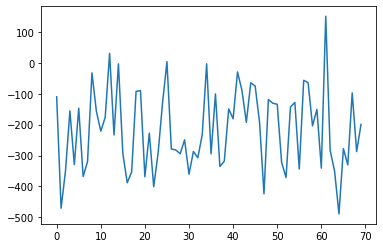

episode 71 --진행 중
episode 72 --진행 중
episode 73 --진행 중
episode 74 --진행 중
episode 75 --진행 중
episode 76 --진행 중
episode 77 --진행 중
episode 78 --진행 중
episode 79 --진행 중
episode 80 --진행 중
===========  에피소드 : 80  ============
최종 누적 보상 : -459.31786453138284
3 [[0.25163767 0.24485947 0.25107595 0.25242692]]


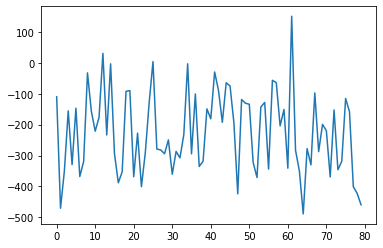

episode 81 --진행 중
episode 82 --진행 중
episode 83 --진행 중
episode 84 --진행 중
episode 85 --진행 중
episode 86 --진행 중
episode 87 --진행 중
episode 88 --진행 중
episode 89 --진행 중
episode 90 --진행 중
===========  에피소드 : 90  ============
최종 누적 보상 : -344.7429851980685
1 [[0.25061795 0.25100866 0.24753362 0.2508398 ]]


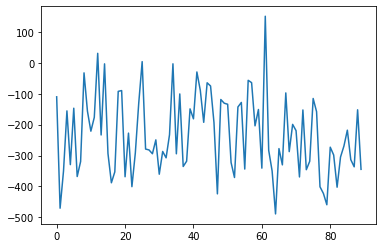

episode 91 --진행 중
episode 92 --진행 중
episode 93 --진행 중
episode 94 --진행 중
episode 95 --진행 중
episode 96 --진행 중
episode 97 --진행 중
episode 98 --진행 중
episode 99 --진행 중
episode 100 --진행 중
===========  에피소드 : 100  ============
최종 누적 보상 : -470.0414422387856
3 [[0.25588483 0.24786824 0.23835303 0.25789383]]


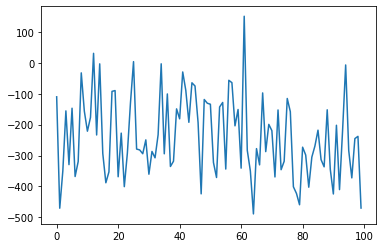

episode 101 --진행 중
episode 102 --진행 중
episode 103 --진행 중
episode 104 --진행 중
episode 105 --진행 중
episode 106 --진행 중
episode 107 --진행 중
episode 108 --진행 중
episode 109 --진행 중
episode 110 --진행 중
===========  에피소드 : 110  ============
최종 누적 보상 : -240.96350238239995
0 [[0.26179388 0.23741014 0.24703267 0.25376332]]


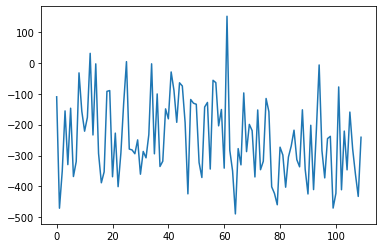

episode 111 --진행 중
episode 112 --진행 중
episode 113 --진행 중
episode 114 --진행 중
episode 115 --진행 중
episode 116 --진행 중
episode 117 --진행 중
episode 118 --진행 중
episode 119 --진행 중
episode 120 --진행 중
===========  에피소드 : 120  ============
최종 누적 보상 : -278.1822423431507
0 [[0.25727856 0.24769449 0.24296257 0.2520643 ]]


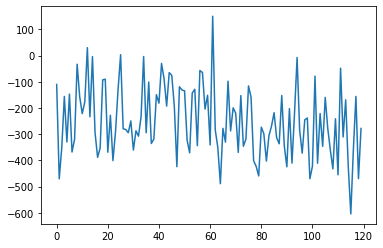

episode 121 --진행 중
episode 122 --진행 중
episode 123 --진행 중
episode 124 --진행 중
episode 125 --진행 중
episode 126 --진행 중
episode 127 --진행 중
episode 128 --진행 중
episode 129 --진행 중
episode 130 --진행 중
===========  에피소드 : 130  ============
최종 누적 보상 : -63.066802484032145
2 [[0.24305594 0.24799733 0.25936413 0.2495826 ]]


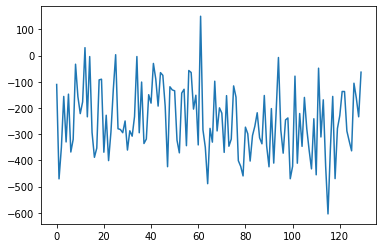

episode 131 --진행 중
episode 132 --진행 중
episode 133 --진행 중
episode 134 --진행 중
episode 135 --진행 중
episode 136 --진행 중
episode 137 --진행 중
episode 138 --진행 중
episode 139 --진행 중
episode 140 --진행 중
===========  에피소드 : 140  ============
최종 누적 보상 : -385.0277804158438
1 [[0.24999358 0.2503389  0.24940756 0.2502599 ]]


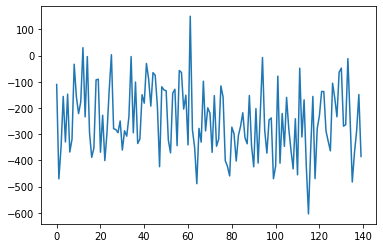

episode 141 --진행 중
episode 142 --진행 중
episode 143 --진행 중
episode 144 --진행 중
episode 145 --진행 중
episode 146 --진행 중
episode 147 --진행 중
episode 148 --진행 중
episode 149 --진행 중
episode 150 --진행 중
===========  에피소드 : 150  ============
최종 누적 보상 : -163.720584584876
1 [[0.2605144  0.2747967  0.23513666 0.22955222]]


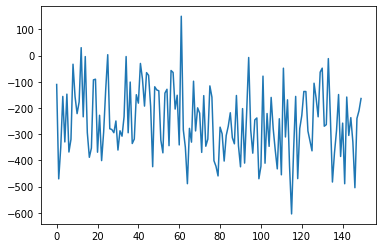

episode 151 --진행 중
episode 152 --진행 중
episode 153 --진행 중
episode 154 --진행 중
episode 155 --진행 중
episode 156 --진행 중
episode 157 --진행 중
episode 158 --진행 중
episode 159 --진행 중
episode 160 --진행 중
===========  에피소드 : 160  ============
최종 누적 보상 : -324.68777559132275
2 [[0.24988689 0.24966565 0.25086716 0.24958038]]


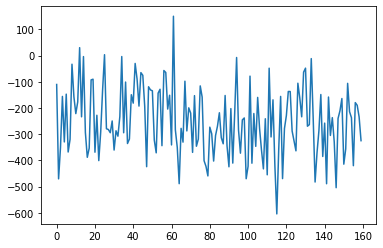

episode 161 --진행 중
episode 162 --진행 중
episode 163 --진행 중
episode 164 --진행 중
episode 165 --진행 중
episode 166 --진행 중
episode 167 --진행 중
episode 168 --진행 중
episode 169 --진행 중
episode 170 --진행 중
===========  에피소드 : 170  ============
최종 누적 보상 : -419.1182518193432
2 [[0.25312728 0.24126677 0.25366202 0.251944  ]]


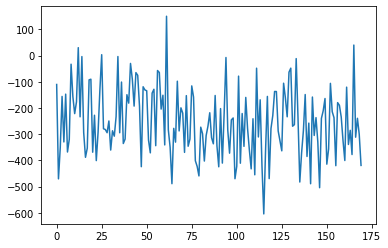

episode 171 --진행 중
episode 172 --진행 중
episode 173 --진행 중


KeyboardInterrupt: ignored

In [11]:
# 그럼, DQN 실행해 보자
env.close()

alpha = 0.1
gamma = 0.999
n_episod = 2000
epsilon = 0.1

cum_rewards = []

for i in range(n_episod) :
    print("episode {} --진행 중".format(i+1))
    env = wrap_env(gym.make("LunarLander-v2"))    
    s0 = env.reset()
    s0 = s0.reshape([1, -1]) # 2차원 어레이로 바꿔주기
    done = False
    cum_r = 0
    while True :
        Q_s0 = Q_network.predict(s0) #s0에서의 action들의 Q_value
        # 행동 선택하기 e-greedy 방법
        if np.random.uniform() < epsilon :
            a0 = env.action_space.sample()
        else : 
            a0 = np.argmax(Q_s0)

        # 환경과 상호작용!
        s1, r1, done, _ = env.step(a0)
        s1 = s1.reshape([1,-1]) # 2차원 어레이로 바꿔주기

        # update Q 제작! 엄청 중요!
        # Q_s0[a0] 만 업데이트가 일어나도록 update용 Q_value를 제작한다.
        Q_s1 = Q_network.predict(s1)
        update_Q = Q_s0.copy() # Q_s0와 다 똑같지만
        update_Q[0][a0] = r1 + gamma*np.max(Q_s1)*(1-done) # 딱 Q[s0, a0] 자리에 이 값을 넣어준다.
        # 1-done의 의미를 탐구해보자.
        ###### Q-table에서 업데이트는 ? #############################################
        ## Q[s0, a0] = Q[s0, a0] + alpha * (r1 + gamma*np.max(Q[s1,:]) - Q[s0, a0]) #
        ## w <-- w + lr * 미분(mean(squart(y - y^))) 유추해서 해석하면
        ## r1 + gamma*np.max(Q[s1,:]) : Y
        ## Q[s0, a0] : Y^ 
        #############################################################################

        Q_network.fit(s0, update_Q, epochs=1, verbose=0)
        
        cum_r = cum_r + r1

        if done == True : # 종료 되었다면
            cum_rewards.append(cum_r)
            env.close() # 환경닫고
            break # 멈추자.

        s0 = s1 # 다음 루프에선 이것이 직전 state

    if (i+1) % 5 == 0 :
            print('===========  에피소드 : {}  ============'.format(i+1))
            print('최종 누적 보상 :',cum_r)
            print(a0, Q_s0)
            plt.plot(cum_rewards)
            plt.show()
            show_video()
        